In [31]:
%reset -f

In [32]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import random as rd # random number generator

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# classifiers
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# from OnkarClassifier import VectorKNNClassifier

In [33]:
#split data method takes in the dataframe, positive label, negative label and the size of the dataframe
#Returns 4 datasets, 2 positive and 2 negative
def split_data(df_total, class_col, pos_label, neg_label, size):
    
    full_pos = df_total[df_total[class_col] == pos_label]
    full_neg = df_total[df_total[class_col] == neg_label]
    
    split_pos_index = round(len(full_pos) * size)
    split_neg_index = round(len(full_neg) * size)
    
    pos1 = full_pos.iloc[:split_pos_index]
    pos2 = full_pos.iloc[split_pos_index:]
    neg1 = full_neg.iloc[:split_neg_index]
    neg2 = full_neg.iloc[split_neg_index:]
    
    return pos1.reset_index(drop=True), pos2.reset_index(drop=True), neg1.reset_index(drop=True), neg2.reset_index(drop=True)

In [34]:
#takes in number of random indices to be selected and the length of the data frame
#returns an array of size shown above and full of random indices
def get_random_indices(num_of_random,len_of_df):
    
    indices = []
    
    for i in range(num_of_random):
        indices.append(rd.randint(0,len_of_df-1))
    
    return indices

In [35]:
#Creating train test set takes in our 4 datasets as created in split_data method
#also takes in the feature columns, class columns and a random number
# num_of_random gives the desired number of random data
#returns x and y train and x and y test
def create_train_test_set(pos1, pos2, neg1, neg2, feature_cols, class_col, num_of_rand):
    
    feature_cols = feature_cols.drop(class_col)

    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()
    
    random_pos_indices = get_random_indices(num_of_rand,len(pos1))
    random_pos = pos1.iloc[random_pos_indices]
    remaining_pos1 = pos1.drop(random_pos_indices)
    
    random_neg_indices = get_random_indices(num_of_rand,len(neg1))
    random_neg = neg1.iloc[random_neg_indices]
    remaining_neg1 = neg1.drop(random_neg_indices)
    
    full_train_set = pd.concat([random_pos,random_neg])
    
    full_remaining_pos = pd.concat([remaining_pos1,pos2])
    full_remaining_neg = pd.concat([remaining_neg1,neg2])
    full_test_set = pd.concat([full_remaining_pos,full_remaining_neg])
    
    X_train = full_train_set[feature_cols]
    y_train = pd.concat([y_train,full_train_set[class_col]])
    
    X_test = full_test_set[feature_cols]
    y_test = pd.concat([y_test,full_test_set[class_col]])
    
    return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

In [36]:
#get entropy takes in a text called info and returns the entropy contained in the info
# info is all the information of a root and children node of a decision tree
#returns an entropy value as a float.
def get_entropy(info):
    
    text = str(info)
    
    parts = text.split('entropy = ')[1]
    entropy_value = parts.split('\\n')[0]

    # Convert the entropy value to a float
    return float(entropy_value)

In [37]:
#Get num of samples takes in a text called info and assigns it to a value
#returns a float of the sample value
#maybe also rename this variable
def get_num_of_samples(info):
    
    text = str(info)
    
    parts = text.split('samples = ')[1]
    num_of_samples = parts.split('\\n')[0]

    # Convert the num of samples to a float
    return float(num_of_samples)

In [38]:
#model metrics takes in the x and y train and creates the model metrics
#returns a dictionary with a graph, tree, parents and children nodes
# which contain their entropies and sample size
def model_metrics(X_train, y_train):
    
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1) # Initialize the decision tree classifier
    clf.fit(X_train, y_train) # Fitting the classifier on the training data
    
    col_names = X_train.columns
    label = y_train.columns[0]
    
    info = plot_tree(clf, feature_names=col_names, class_names=[str(pos_label), str(neg_label)], rounded=True, filled=True)
    
    metrics = {
        'Graph' : info,
        'Tree': clf,
        'e_parent': get_entropy(info[0]),
        'e_child1': get_entropy(info[1]),
        'e_child2' : get_entropy(info[3]),
        'parent_sample' : get_num_of_samples(info[0]),
        'child_sample1' : get_num_of_samples(info[1]),
        'child_sample2' : get_num_of_samples(info[3]),
    }

#     plot_tree(clf, feature_names=col_names, class_names=[str(pos_label), str(neg_label)], rounded=True, filled=True)
#     plt.show()
    
    return metrics

In [39]:
# calculate_information_gain uses entropy values gained from the root and children nodes
# these values come from a decision tree of depth one of a specific attribute
# returns the information gain of the column
def calculate_information_gain(metrics):
    
    return metrics['e_parent']-((metrics['child_sample1']/metrics['parent_sample'])*metrics['e_child1'])-((metrics['child_sample2']/metrics['parent_sample'])*metrics['e_child2'])

In [40]:
#takes in x and y train, label col and columns
#then returns our information gain weights
def get_information_gain(X_train, y_train, label_col, columns):
    
    information_gain_weights = pd.DataFrame()
    col_names = columns[:-1]
    current_information_gain = np.array([])

    
    for col in columns:
        if col != label_col:
            metrics = model_metrics(X_train[[col]], y_train)
            current_information_gain = np.append(current_information_gain, calculate_information_gain(metrics))
    current_information_gain = current_information_gain.reshape(1,-1)
    information_gain_weights = pd.DataFrame(current_information_gain, columns=col_names)

    return information_gain_weights

In [41]:
#avg info gain takes in the data frame called df_gain
#returns the results in a dataframe and an average information gain array
def get_avg_info_gain_df(df_gain):
    # Compute the mean of each column in the DataFrame
    avg_info_gain = df_gain.mean()
    
    # Convert the resulting Series to a NumPy array
    avg_info_gain_array = avg_info_gain.to_numpy()
    
    # Create a DataFrame from the average coefficients
    avg_info_gain_df = pd.DataFrame([avg_info_gain], columns=df_gain.columns, index=['avg'])
    
    # Concatenate the original DataFrame with the average coefficients DataFrame
    result_df = pd.concat([df_gain, avg_info_gain_df], ignore_index=False)
    
    return result_df, avg_info_gain_array

In [42]:
#Run simulation takes in a simulation length number (number of times information gain is calculated for each attribute ) 
# a total data frame, label column, positive and negative label, size and number of rand
# num_of_rand allows for n random data 
#returns average info gain dataframe and array, x and y text, and x and y train
def run_simulation(sim_len, df_total, label_col,pos_label, neg_label, size, num_of_rand):
    
    sim_info_gain = pd.DataFrame()
    
    positive1, positive2, negative1, negative2 = split_data(df_total, label_col, pos_label, neg_label, size)

    
    for i in range(sim_len):
        
        X_train, y_train, X_test, y_test = create_train_test_set(positive1, positive2, negative1, negative2, df_total.columns, label_col, num_of_rand)
        
        info_gain = get_information_gain(X_train, y_train, label_col, df_total.columns)
        
        sim_info_gain = pd.concat([info_gain, sim_info_gain])
        
    avg_info_gain_df, avg_info_gain_array = get_avg_info_gain_df(sim_info_gain)
        
    return avg_info_gain_df, avg_info_gain_array, X_test, y_test, X_train, y_train
    

In [43]:
# analogous to get information gain function 
def get_explained_variance(pca,feature_cols):
    
    explained_variance= pca.explained_variance_ratio_
    explained_variance = explained_variance.reshape(1,-1)

    ev_df = pd.DataFrame(explained_variance, columns=feature_cols)
    
    return ev_df

In [44]:
# analogous to get avg information gain function 
def get_avg_explained_variance_df(df_ev):
    # Compute the mean of each column in the DataFrame
    avg_ev = df_ev.mean()

    # Convert the resulting Series to a NumPy array
    avg_ev_array = avg_ev.to_numpy()

    # Create a DataFrame from the average coefficients
    avg_ev_df = pd.DataFrame([avg_ev], columns=df_ev.columns, index=['avg'])

    # Concatenate the original DataFrame with the average coefficients DataFrame
    result_df = pd.concat([df_ev, avg_ev_df], ignore_index=False)

    return result_df, avg_ev_array

In [45]:
# mod run simulation is a function similar to the one above 
# but uses explained variance PCA instead of Information gain
#returns average explained variance dataframe and array, x and y text, and x and y train
def mod_run_simulation(sim_len, df_total, label_col,pos_label, neg_label, size, num_of_rand):

    sim_explained_variance = pd.DataFrame()
    
    pca = PCA(n_components=13)
    pc = pca.fit_transform(df_heart_standardized.iloc[:-1])

    df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                        'principal component 4', 'principal component 5', 'principal component 6',
                                        'principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13'])

    final_pca_df = pd.concat([df_pca, df_heart_standardized[['num']]], axis = 1)

    phishing1, phishing2, non_phishing1, non_phishing2 = split_data(final_pca_df, label_col, pos_label, neg_label, size)

    for i in range(sim_len):

        X_train, y_train, X_test, y_test = create_train_test_set(phishing1, phishing2, non_phishing1, non_phishing2, final_pca_df.columns, label_col, num_of_rand)

        explained_variance = get_explained_variance(pca,df_pca.columns)
        sim_explained_variance = pd.concat([explained_variance, sim_explained_variance])
    

    avg_explained_variance_df, avg_explained_variance_array = get_avg_explained_variance_df(sim_explained_variance)

    return avg_explained_variance_df, avg_explained_variance_array, X_test, y_test, X_train, y_train


In [46]:
column_names = [
  'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
  'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

df_heart = pd.read_csv('heartdiseaes/processed.cleveland.data', names = column_names, index_col = False)

new_row_values = [63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3.0, 0, 6.0, 0]

df_heart.loc[0] = new_row_values

In [47]:
for i in df_heart.itertuples():
    tup = i
    for j in tup:
        if j == '?':
            print(tup)

Pandas(Index=87, age=53.0, sex=0.0, cp=3.0, trestbps=128.0, chol=216.0, fbs=0.0, restecg=2.0, thalach=115.0, exang=0.0, oldpeak=0.0, slope=1.0, ca='0.0', thal='?', num=0)
Pandas(Index=166, age=52.0, sex=1.0, cp=3.0, trestbps=138.0, chol=223.0, fbs=0.0, restecg=0.0, thalach=169.0, exang=0.0, oldpeak=0.0, slope=1.0, ca='?', thal='3.0', num=0)
Pandas(Index=192, age=43.0, sex=1.0, cp=4.0, trestbps=132.0, chol=247.0, fbs=1.0, restecg=2.0, thalach=143.0, exang=1.0, oldpeak=0.1, slope=2.0, ca='?', thal='7.0', num=1)
Pandas(Index=266, age=52.0, sex=1.0, cp=4.0, trestbps=128.0, chol=204.0, fbs=1.0, restecg=0.0, thalach=156.0, exang=1.0, oldpeak=1.0, slope=2.0, ca='0.0', thal='?', num=2)
Pandas(Index=287, age=58.0, sex=1.0, cp=2.0, trestbps=125.0, chol=220.0, fbs=0.0, restecg=0.0, thalach=144.0, exang=0.0, oldpeak=0.4, slope=2.0, ca='?', thal='7.0', num=0)
Pandas(Index=302, age=38.0, sex=1.0, cp=3.0, trestbps=138.0, chol=175.0, fbs=0.0, restecg=0.0, thalach=173.0, exang=0.0, oldpeak=0.0, slope=1

In [48]:
row_nums = [87,166,192,266,287,302]
df_heart = df_heart.drop(row_nums)

In [49]:
df_heart.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

In [50]:
df_heart['ca'] = pd.to_numeric(df_heart['ca'])

In [51]:
df_heart['thal'] = pd.to_numeric(df_heart['thal'])

In [52]:
df_heart['num'] = df_heart['num'].replace([1,2,3,4], 1)

In [53]:
def standardizer(df):
    
    temp_df = df.copy()
    
    for col in temp_df.columns[:-1]:
        
        temp_df[col] = (temp_df[col] - temp_df[col].mean())/temp_df[col].std()
        
    return temp_df

In [54]:
df_heart_standardized = standardizer(df_heart)

In [55]:
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [56]:
df_heart_standardized.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.934603,0.689930,-2.236854,0.749116,-0.275978,2.426332,1.008496,0.017465,-0.695246,1.067164,2.260330,-0.720760,0.654772,0
1,1.376605,0.689930,0.872408,1.593577,0.743301,-0.410757,1.008496,-1.813274,1.433497,0.381130,0.642696,2.474249,-0.892713,1
2,1.376605,0.689930,0.872408,-0.658320,-0.352904,-0.410757,1.008496,-0.897904,1.433497,1.324427,0.642696,1.409246,1.170601,1
3,-1.938409,0.689930,-0.164013,-0.095345,0.050961,-0.410757,-1.001728,1.630258,-0.695246,2.096215,2.260330,-0.720760,-0.892713,0
4,-1.496407,-1.444542,-1.200433,-0.095345,-0.833696,-0.410757,1.008496,0.976423,-0.695246,0.295376,-0.974938,-0.720760,-0.892713,0


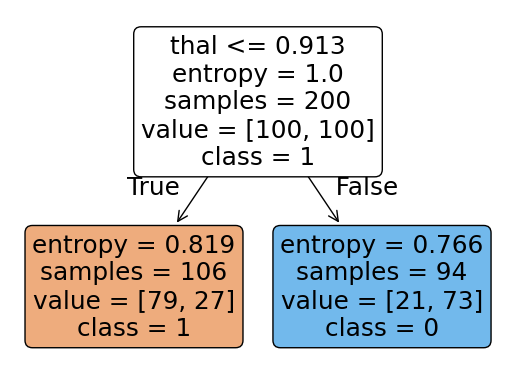

In [57]:
sim_len = 100
label_col = 'num'
pos_label = 1
neg_label = 0
size = .5
num_of_rand = 100
heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)

<p>1st process is getting sqaured difference </p>
<p>2nd weights dot squared diff </p>
<p>3rd sort resulting list</p>
<p>4th return k neighbors </p>
<p> 5th classify</p>

In [58]:
#a and b are rows here. 
def Euclid_Distance(a,b,weights,Columns,Class):
    c=Columns 
    D=0
    for i in range(len(c)-1):
        if c[i]!=Class:
            D+=(weights[i]**2)*(float(a[c[i]])-float(b[c[i]]))**2
    return D**0.5


def Nearest_Neighbors(point,List_Pot_Nbrs,weights,Class_Col_Name):
    ClassWithDistance=[]
    d=0
    for n in range(len(List_Pot_Nbrs)):
        d=Euclid_Distance(point,List_Pot_Nbrs.iloc[n],weights,List_Pot_Nbrs.columns,Class_Col_Name)
        ClassWithDistance+=[[d,List_Pot_Nbrs.iloc[n][Class_Col_Name]]]
    sorted_list = sorted(ClassWithDistance, key=lambda x: x[0])
    
    return sorted_list

def KNN(k,Sorted_List):
    Sum=0
    for i in range(k):
        if Sorted_List[i][1]==1:
            Sum+=1
    if Sum>k/2:
        return 1
    else:
        return 0
    
def ConfusionMatrix(TrP,TrN,FaP,FaN):
    print("         Confusion Matrix")
    print("TN,FP: ",TrN, "    ,    ", FaP)
    print("FN,TP: ",FaN,"     ,    ", TrP)


In [59]:
def specificity_score(TN,FP):
    
    return TN/(TN+FP)

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x1244a4400>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


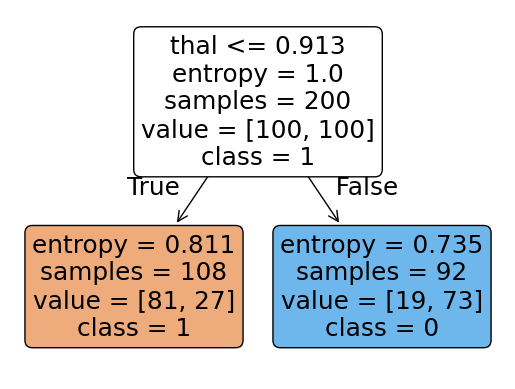

In [60]:
from sklearn.metrics import confusion_matrix

avg_acc = []
avg_precision = []
avg_recall = []
avg_f1 = []
avg_specificity = []

weight_avg_acc = []
weight_avg_precision = []
weight_avg_recall = []
weight_avg_f1 = []
weight_avg_specificity = []

dropped_weight_avg_acc = []
dropped_weight_avg_precision = []
dropped_weight_avg_recall = []
dropped_weight_avg_f1 = []
dropped_weight_avg_specificity = []

pca_avg_acc = []
pca_avg_precision = []
pca_avg_recall = []
pca_avg_f1 = []
pca_avg_specificity = []

pca_explained_variance_acc = []
pca_explained_variance_precision = []
pca_explained_variance_recall = []
pca_explained_variance_f1 = []
pca_explained_variance_specificity = []

NN_acc = []
NN_precision = []
NN_recall = []
NN_f1 = []
NN_specificity = []

RFC_acc = []
RFC_precision = []
RFC_recall = []
RFC_f1 = []
RFC_specificity = []

XGB_acc = []
XGB_precision = []
XGB_recall = []
XGB_f1 = []
XGB_specificity = []

sim_len = 50
label_col = 'num'
pos_label = 1
neg_label = 0
size = .5
num_of_rand = 100

heart_swagger = []


# Loops the length of the simulation

for i in range(sim_len):
    
    heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)
    Train_Data =  pd.concat([heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([heart_X_test, heart_y_test], axis=1)
    
    TP=0
    TN=0
    FP=0
    FN=0
    
    
    # non weighted k-NN for all attributes
    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, [1,1,1,1,1,1,1,1,1,1,1,1,1], "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_non_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_non_weighted = TP/(TP+FP)
    recall_non_weighted = TP/(TP+FN)
    f1_non_weighted = (2 * precision_non_weighted * recall_non_weighted)/(precision_non_weighted+recall_non_weighted)
    specificity_non_weighted = specificity_score(TN,FP)
    
    
#     print("Accurecy:", A)
#     ConfusionMatrix(TP,TN,FP,FN)
    avg_acc.append(A_non_weighted*100)
    avg_precision.append(precision_non_weighted*100)
    avg_recall.append(recall_non_weighted*100)
    avg_f1.append(f1_non_weighted*100)
    avg_specificity.append(specificity_non_weighted*100)

    TP=0
    TN=0
    FP=0
    FN=0

    # weighted information gain k-NN with all attributes 
    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data,  heart_avg_info_gain_array, "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_weighted = TP/(TP+FP)
    recall_weighted = TP/(TP+FN)
    f1_weighted = (2 * precision_weighted * recall_weighted)/(precision_weighted+recall_weighted)
    specificity_weighted = specificity_score(TN,FP)

    weight_avg_acc.append(A_weighted*100)
    weight_avg_precision.append(precision_weighted*100)
    weight_avg_recall.append(recall_weighted*100)
    weight_avg_f1.append(f1_weighted*100)
    weight_avg_specificity.append(specificity_weighted*100)
    
    # dropping some columns as feature selections
    alpha = .1
    count = 0
    heart_swagger = []
    heart_indices = []  # Array to store the indices

    for idx, ig in enumerate(heart_avg_info_gain_array):
        if ((ig / max(heart_avg_info_gain_array)) ** 2 < alpha):
            count += 1
            heart_indices.append(idx)  # Append the index
        else:
            heart_swagger.append(ig)

    dropped_heart_X_train = heart_X_train.drop(heart_X_train.columns[heart_indices],axis=1)
    dropped_heart_X_test = heart_X_test.drop(heart_X_test.columns[heart_indices],axis=1)

    Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)

    TP=0
    TN=0
    FP=0
    FN=0

    # weighted k-NN with dropped columns using information gain with dropped columns
    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_dropped_weighted = TP/(TP+FP)
    recall_dropped_weighted = TP/(TP+FN)
    f1_dropped_weighted = (2 * precision_dropped_weighted * recall_dropped_weighted)/(precision_dropped_weighted+recall_dropped_weighted)
    specificity_dropped_weighted = specificity_score(TN,FP)

    dropped_weight_avg_acc.append(A_dropped_weighted*100)
    dropped_weight_avg_precision.append(precision_dropped_weighted*100)
    dropped_weight_avg_recall.append(recall_dropped_weighted*100)
    dropped_weight_avg_f1.append(f1_dropped_weighted*100)
    dropped_weight_avg_specificity.append(specificity_dropped_weighted*100)
    
    
    # PCA components brining all attributes to 7 
    pca = PCA(n_components=7)
    pc = pca.fit_transform(heart_X_train)
    pca2 = PCA(n_components=7)
    pc2 = pca.fit_transform(heart_X_test)

    df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                            'principal component 4', 'principal component 5', 'principal component 6',
                                            'principal component 7'])
    df_pca2 = pd.DataFrame(data=pc2, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                          'principal component 4', 'principal component 5', 'principal component 6',
                                          'principal component 7'])

    final_train_pca_df = pd.concat([df_pca, heart_y_train[['num']]], axis = 1)
    final_test_pca_df = pd.concat([df_pca2, heart_y_train[['num']]], axis = 1)

    Train_Data =  final_train_pca_df
    Test_Data = final_test_pca_df

    TP=0
    TN=0
    FP=0
    FN=0

    # PCA k-NN
    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, [1,1,1,1,1,1,1,1,1,1,1,1,1] , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    
    A_pca=(TP+TN)/(TP+TN+FP+FN)
    precision_pca = TP/(TP+FP)
    recall_pca = TP/(TP+FN)
    f1_pca = (2 * precision_pca * recall_pca)/(precision_pca+recall_pca)
    specificity_pca = specificity_score(TN,FP)

    pca_avg_acc.append(A_pca*100)
    pca_avg_precision.append(precision_pca*100)
    pca_avg_recall.append(recall_pca*100)
    pca_avg_f1.append(f1_pca*100)
    pca_avg_specificity.append(specificity_pca*100)
    
    
    # Explained Variance k-NN 
    ev_heart_avg_ev_df, ev_heart_avg_ev_array, ev_heart_X_test, ev_heart_y_test, ev_heart_X_train, ev_heart_y_train = mod_run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)


    alpha = .1
    count = 0
    ev_heart_swagger = []
    ev_heart_indices = []  # Array to store the indices

    for idx, ev in enumerate(ev_heart_avg_ev_array):
        if ev < (alpha ** 1 / 2)*max(ev_heart_avg_ev_array):
            count += 1
            ev_heart_indices.append(idx)  # Append the index
        else:
            ev_heart_swagger.append(ev)

    ev_dropped_heart_X_train = ev_heart_X_train.drop(ev_heart_X_train.columns[ev_heart_indices],axis=1)
    ev_dropped_heart_X_test = ev_heart_X_test.drop(ev_heart_X_test.columns[ev_heart_indices],axis=1)

    Train_Data =  pd.concat([ev_dropped_heart_X_train, ev_heart_y_train], axis=1)
    Test_Data = pd.concat([ev_dropped_heart_X_test, ev_heart_y_test], axis=1)

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, ev_heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_pca_ev=(TP+TN)/(TP+TN+FP+FN)
    precision_pca_ev = TP/(TP+FP)
    recall_pca_ev = TP/(TP+FN)
    f1_pca_ev = (2 * precision_pca_ev * recall_pca_ev)/(precision_pca_ev+recall_pca_ev)
    specificity_pca_ev = specificity_score(TN,FP)

    pca_explained_variance_acc.append(A_pca*100)
    pca_explained_variance_precision.append(precision_pca*100)
    pca_explained_variance_recall.append(recall_pca*100)
    pca_explained_variance_f1.append(f1_pca*100)
    pca_explained_variance_specificity.append(specificity_pca*100)
    
    
    # Neural Network Classifier 
    clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,
                           hidden_layer_sizes=(5, 2), max_iter=1000, random_state=1)
    clf_NN.fit(dropped_heart_X_train, heart_y_train.values.ravel())
    
    NN_prediction = clf_NN.predict(dropped_heart_X_test)

    TN, FP, FN, TP = confusion_matrix(heart_y_test, NN_prediction, labels=[0, 1]).ravel()
    
    NN_acc.append(accuracy_score(heart_y_test, NN_prediction) * 100)
    NN_precision.append(precision_score(heart_y_test, NN_prediction) * 100)
    NN_recall.append(recall_score(heart_y_test, NN_prediction) * 100)
    NN_f1.append(f1_score(heart_y_test, NN_prediction) * 100)
    NN_specificity.append(specificity_score(TN, FP) * 100)
    

    # Random Forest Classifier 
    clf_RFC = RandomForestClassifier(max_depth=2, random_state=0)
    clf_RFC.fit(dropped_heart_X_train, heart_y_train.values.ravel())

    RFC_prediction = clf_NN.predict(dropped_heart_X_test)

    TN, FP, FN, TP = confusion_matrix(heart_y_test, RFC_prediction, labels=[0, 1]).ravel()
    
    RFC_acc.append(accuracy_score(heart_y_test, RFC_prediction) * 100)
    RFC_precision.append(precision_score(heart_y_test, RFC_prediction) * 100)
    RFC_recall.append(recall_score(heart_y_test, RFC_prediction) * 100)
    RFC_f1.append(f1_score(heart_y_test, RFC_prediction) * 100)
    RFC_specificity.append(specificity_score(TN, FP) * 100)
    
    # XG Boost Classifier 
    clf_XGB = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

    clf_XGB.fit(dropped_heart_X_train, heart_y_train.values.ravel())
    
    XGB_prediction = clf_XGB.predict(dropped_heart_X_test)

    TN, FP, FN, TP = confusion_matrix(heart_y_test, XGB_prediction, labels=[0, 1]).ravel()
    
    XGB_acc.append(accuracy_score(heart_y_test, XGB_prediction) * 100)
    XGB_precision.append(precision_score(heart_y_test, XGB_prediction) * 100)
    XGB_recall.append(recall_score(heart_y_test, XGB_prediction) * 100)
    XGB_f1.append(f1_score(heart_y_test, XGB_prediction) * 100)
    XGB_specificity.append(specificity_score(TN, FP) * 100)

<h1 style="text-align:center;">Accuracy</h1>


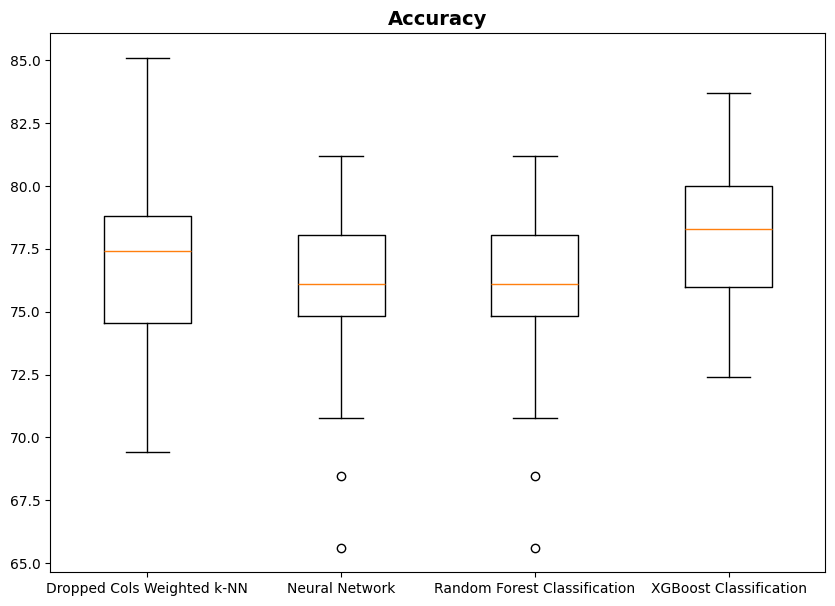

In [61]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')

data = [dropped_weight_avg_acc, NN_acc, RFC_acc, XGB_acc]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Accuracy.svg')

# show plot
plt.show()

<h1 style="text-align:center;">Specificity</h1>


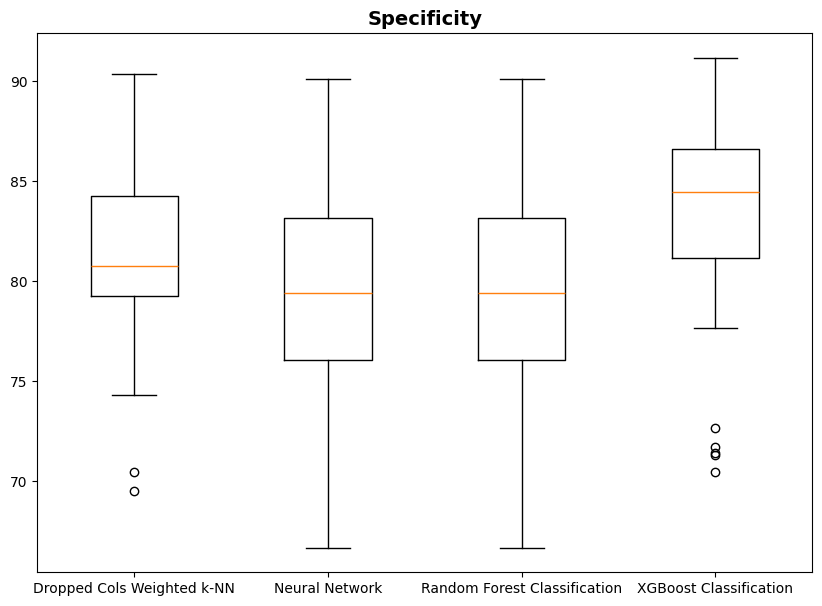

In [62]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_specificity, NN_specificity, RFC_specificity , XGB_specificity]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Specificity.svg')
# show plot
plt.show()

<h1 style="text-align:center;">F1</h1>


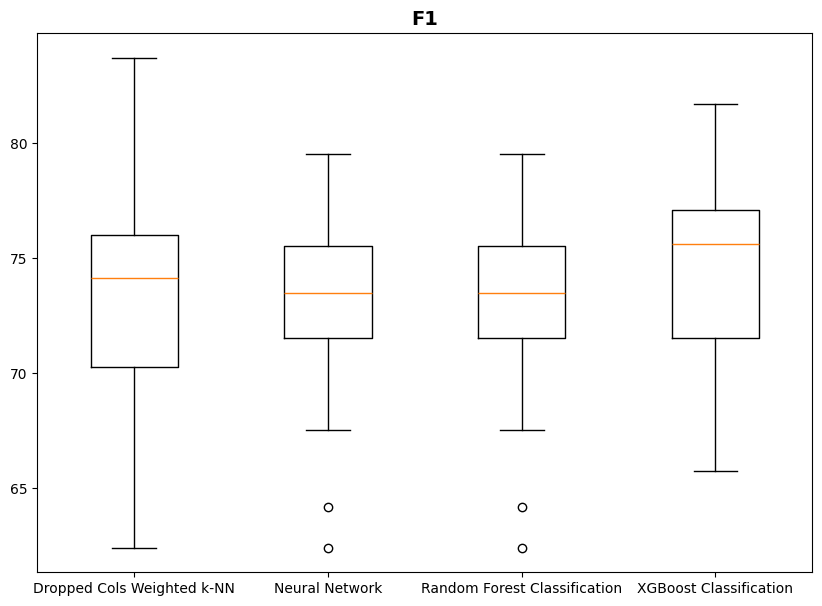

In [63]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_f1, NN_f1, RFC_f1 , XGB_f1]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('F1.svg')
# show plot
plt.show()

<h1 style="text-align:center;">Recall</h1>

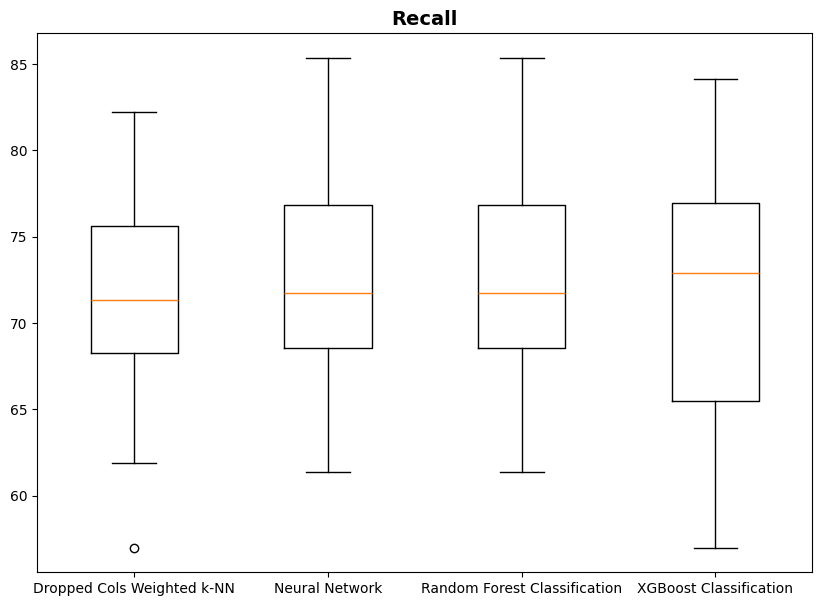

In [64]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_recall, NN_recall, RFC_recall , XGB_recall]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Recall.svg')
# show plot
plt.show()

<h1 style=text-align:center;>Precision</h1>

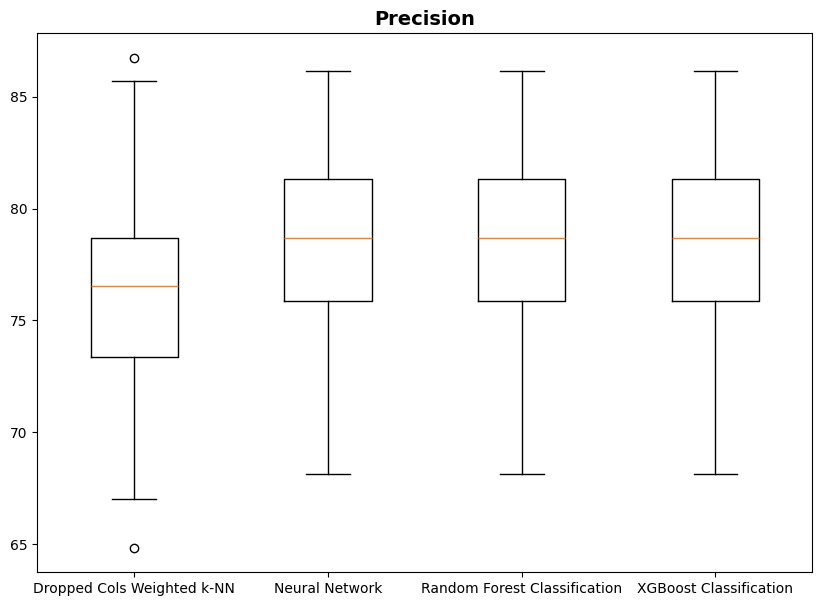

In [65]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_precision,XGB_precision, XGB_precision , XGB_precision]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Precision.svg')
# show plot
plt.show()

In [66]:
# fig = plt.figure(figsize =(10, 7))
# plt.title("Accuracy",fontsize=14, fontweight='bold')
# 
# data = [dropped_weight_acc, NN_acc, RFC_acc, XGB_acc]
# 
# x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']
# 
# # Creating plot
# plt.boxplot(data, tick_labels=x_axis)
# 
# # plt.savefig('Accuracy.svg')
# 
# # show plot
# plt.show()

In [67]:
import statistics
statistics.mean(avg_acc)

78.3319156409394

In [68]:
statistics.mean(NN_acc)

76.16129132638123

<h1 style="text-align:center;">These are the Boxplots Including Regular PCA</h1>


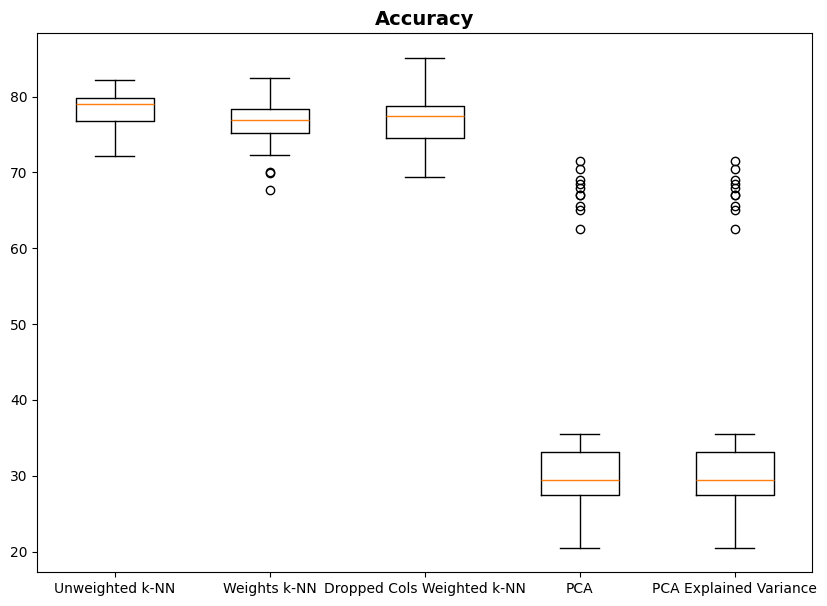

In [69]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')


data = [avg_acc,weight_avg_acc ,dropped_weight_avg_acc, pca_avg_acc, pca_explained_variance_acc]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Accuracy.svg')

# show plot
plt.show()

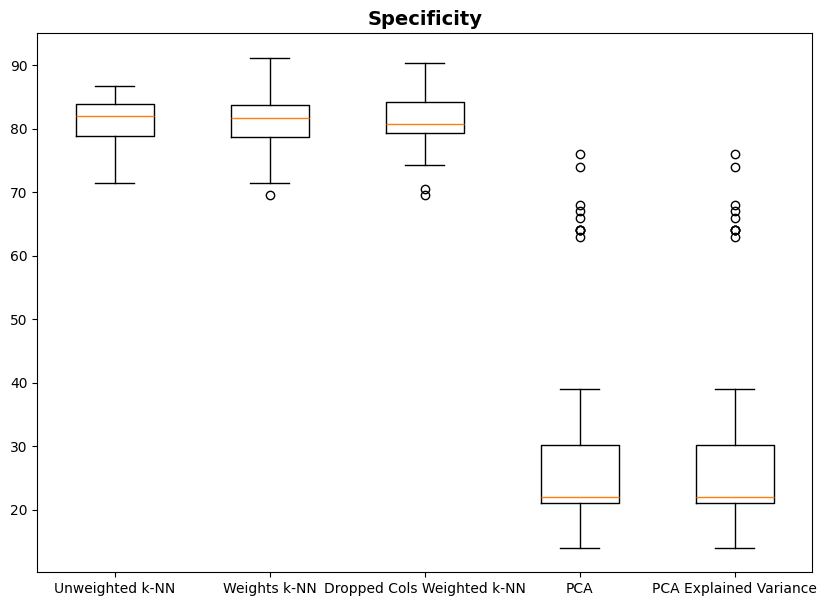

In [70]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [avg_specificity, weight_avg_specificity, dropped_weight_avg_specificity, pca_avg_specificity, pca_explained_variance_specificity]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Specificity.svg')
# show plot
plt.show()

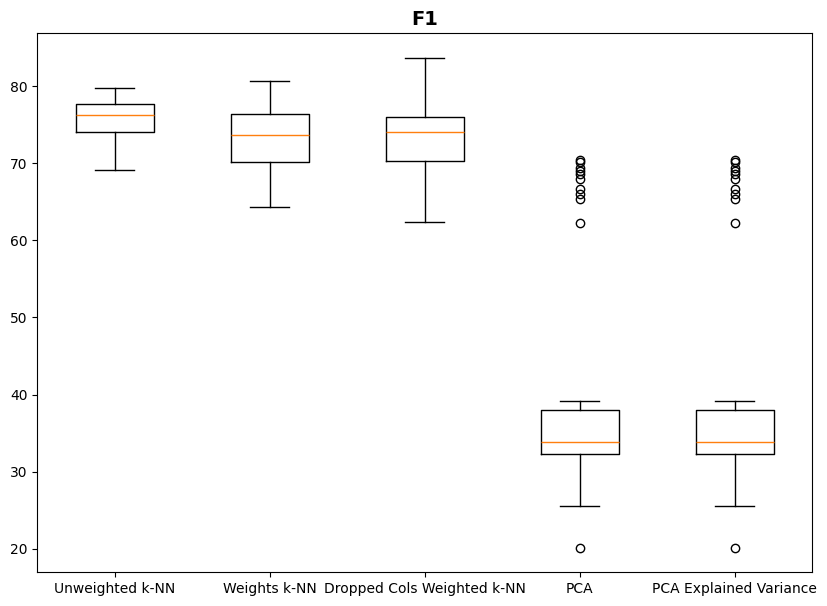

In [71]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [avg_f1, weight_avg_f1, dropped_weight_avg_f1, pca_avg_f1, pca_explained_variance_f1]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('F1.svg')

# show plot
plt.show()

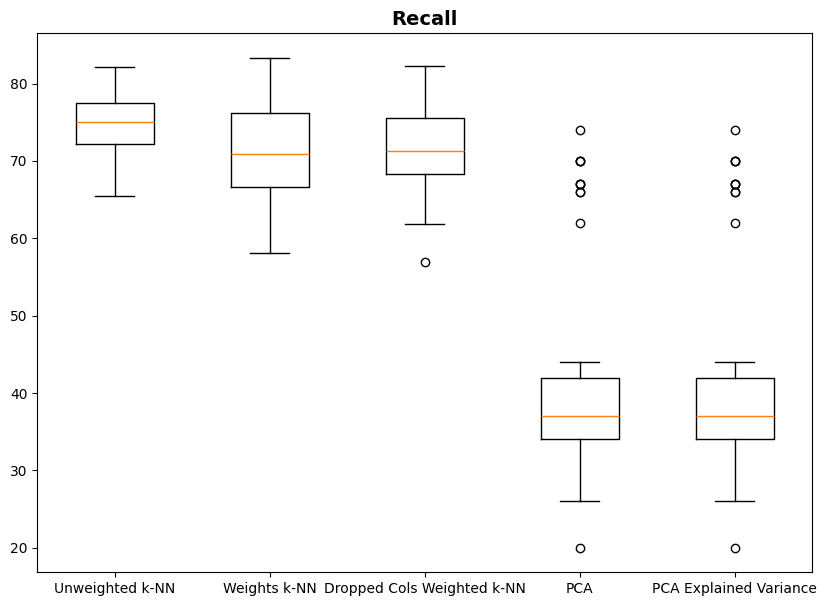

In [72]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [avg_recall,weight_avg_recall, dropped_weight_avg_recall, pca_avg_recall, pca_explained_variance_recall]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Recall.svg')

# show plot
plt.show()

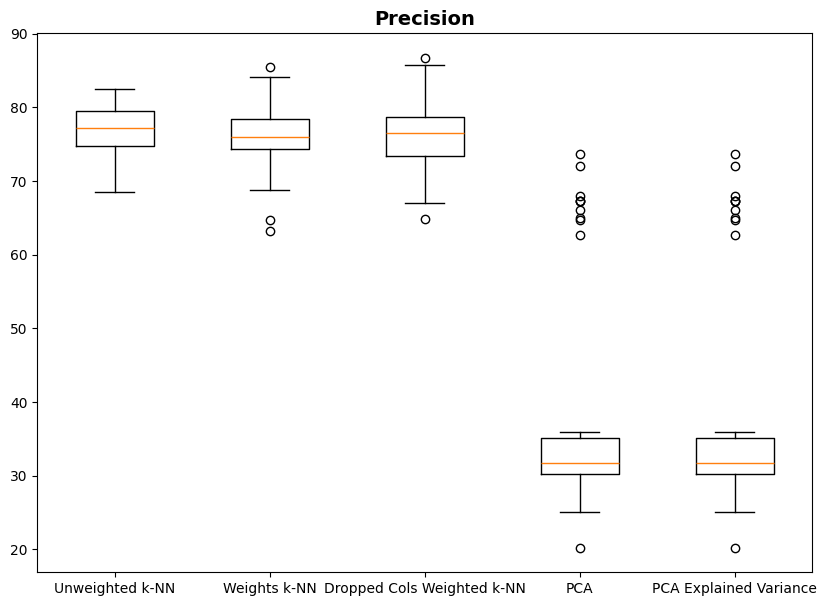

In [73]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [avg_precision, weight_avg_precision, dropped_weight_avg_precision, pca_avg_precision, pca_explained_variance_precision]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Precision.svg')

# show plot
plt.show()

<h1 style="text-align:center;">These are the Boxplots Without Regular PCA</h1>

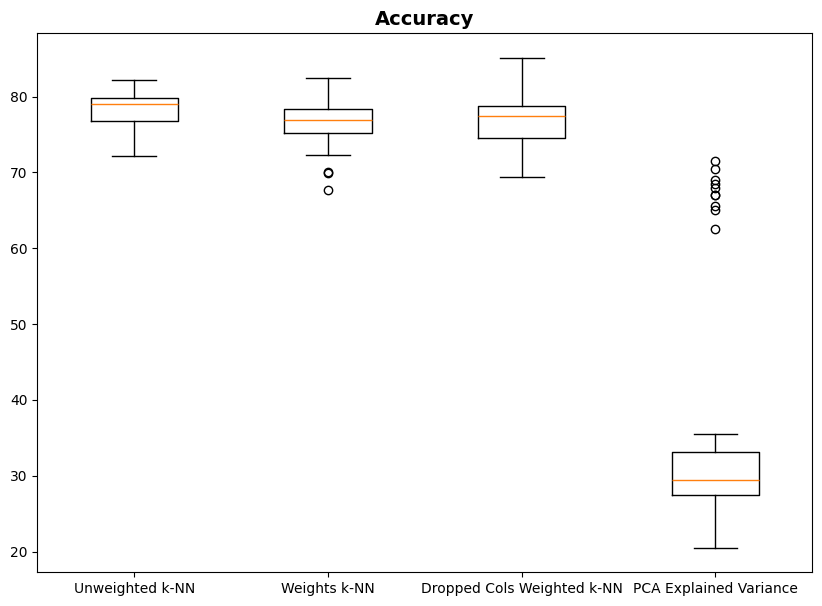

In [74]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')


data = [avg_acc,weight_avg_acc ,dropped_weight_avg_acc,pca_explained_variance_acc]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

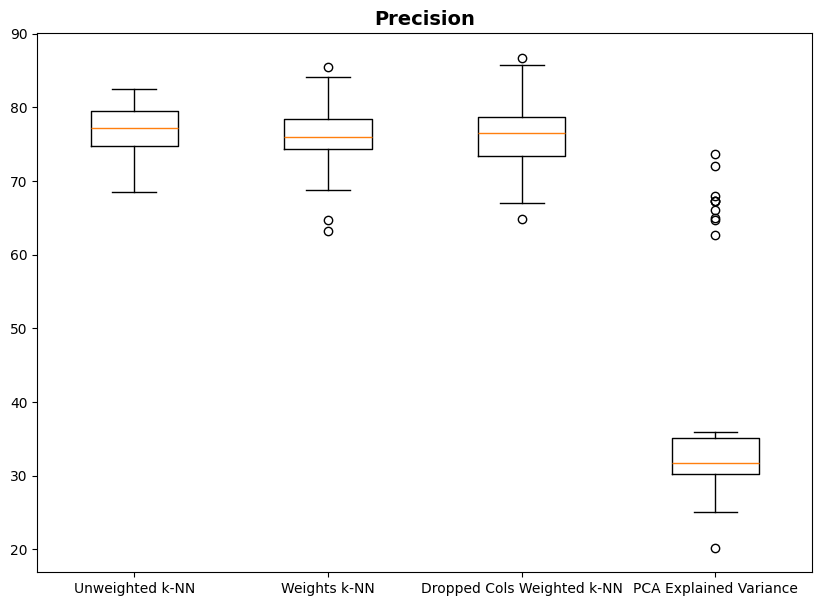

In [75]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [avg_precision,weight_avg_precision ,dropped_weight_avg_precision,pca_explained_variance_precision]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

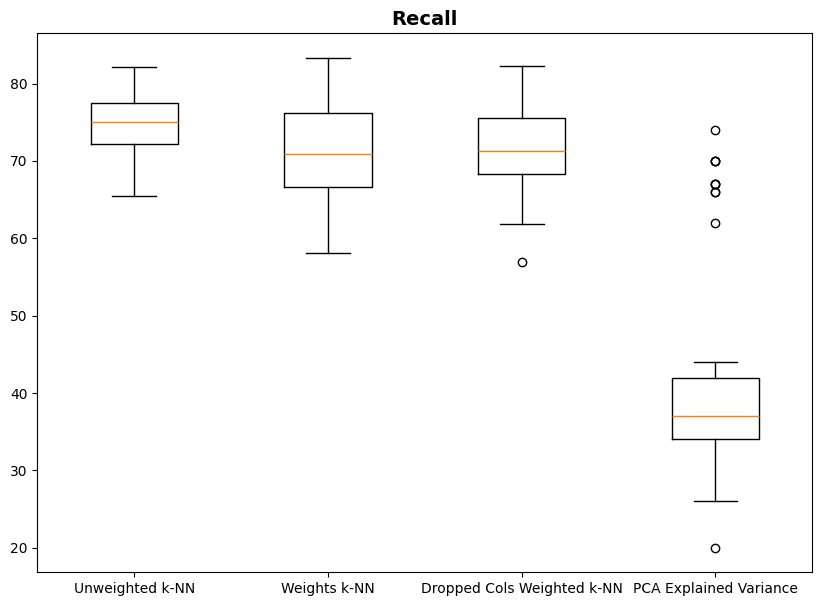

In [76]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [avg_recall,weight_avg_recall ,dropped_weight_avg_recall,pca_explained_variance_recall]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

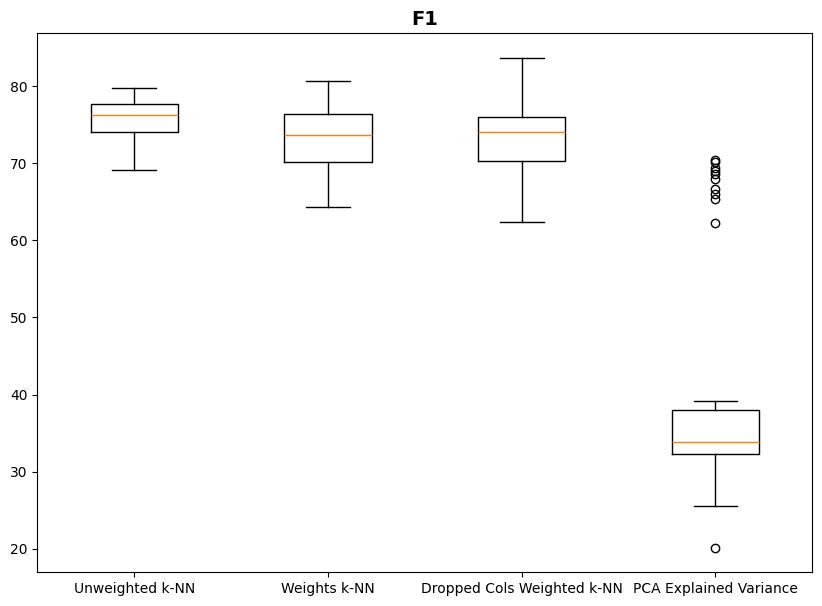

In [77]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [avg_f1,weight_avg_f1 ,dropped_weight_avg_f1,pca_explained_variance_f1]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

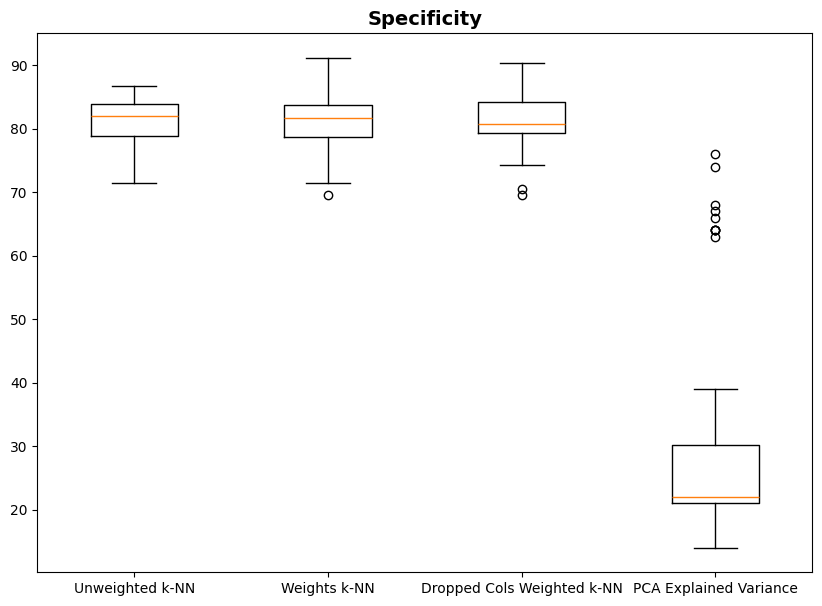

In [78]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [avg_specificity,weight_avg_specificity ,dropped_weight_avg_specificity,pca_explained_variance_specificity]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

In [79]:
min(data[0])

71.42857142857143

In [80]:
min(data[1])

69.52380952380952

In [81]:
min(data[2])

69.52380952380952

In [82]:
min(data[3])

14.000000000000002

In [83]:
max(data[0])

86.66666666666667

In [84]:
max(data[1])

91.17647058823529

In [85]:
max(data[2])

90.38461538461539

In [86]:
max(data[3])

76.0

In [87]:
pca = PCA(n_components=len(dropped_heart_X_train.columns))
pc = pca.fit_transform(dropped_heart_X_train)
pca2 = PCA(n_components=len(dropped_heart_X_test.columns))
pc2 = pca.fit_transform(dropped_heart_X_test)

In [88]:
pc

array([[ 1.24248554, -1.19179745,  0.948529  , ..., -0.4357117 ,
        -0.32968345, -0.6016945 ],
       [ 0.75524026,  0.69629384, -0.32679952, ..., -1.01383152,
        -0.81696844,  0.96011071],
       [ 1.9661344 , -1.3854522 , -2.52754606, ..., -0.02116163,
         0.32567523,  0.92441673],
       ...,
       [-1.92787839,  0.07447792, -0.33729554, ..., -0.80031606,
         0.72549054,  0.20040482],
       [-1.01575834, -0.21221548,  2.1582135 , ..., -0.52729832,
         1.66547764, -0.87142011],
       [-2.04471425,  1.08575785, -1.0564727 , ...,  0.70507783,
        -0.2550955 ,  0.23499953]])

In [89]:
dropped_heart_X_train.head()

,cp,thalach,exang,oldpeak,slope,ca,thal
0,-1.200433,-2.031219,-0.695246,0.295376,0.642696,0.344243,1.170601
1,0.872408,-0.244069,1.433497,0.123867,0.642696,0.344243,-0.892713
2,0.872408,0.453355,-0.695246,2.181970,2.260330,1.409246,-0.892713
3,0.872408,-0.200480,1.433497,-0.219150,0.642696,0.344243,1.170601
4,0.872408,0.366177,-0.695246,-0.390658,-0.974938,1.409246,0.654772


In [90]:
pc2

array([[ 2.81536032,  0.68166349, -0.43382647, ...,  0.27282679,
         0.30533995,  0.15072129],
       [ 0.86301375,  0.27253494, -0.50877179, ..., -0.43896219,
        -1.29760798, -0.21484351],
       [ 2.53435944, -1.87204163, -0.63457882, ...,  0.99009755,
        -0.42478336, -0.10012084],
       ...,
       [-1.22243825, -1.85041292, -1.05309587, ...,  0.44900854,
        -0.43548284, -1.84377642],
       [-1.93089046, -0.35299163, -0.42769586, ...,  0.02857552,
         0.41562682,  0.8603492 ],
       [-2.64065971, -0.12449499, -0.09665207, ...,  0.3118474 ,
         0.35198077,  0.04949925]])

In [91]:
df_pca = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4', 'principal component 5', 'principal component 6','principal component 7'])
df_pca2 = pd.DataFrame(data = pc2, columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4', 'principal component 5', 'principal component 6','principal component 7'])


In [92]:
final_train_pca_df = pd.concat([df_pca, heart_y_train[['num']]], axis = 1)
final_test_pca_df = pd.concat([df_pca2, heart_y_train[['num']]], axis = 1)

In [93]:
final_train_pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,num
0,1.242486,-1.191797,0.948529,-1.674101,-0.435712,-0.329683,-0.601694,1.0
1,0.755240,0.696294,-0.326800,1.131097,-1.013832,-0.816968,0.960111,1.0
2,1.966134,-1.385452,-2.527546,0.868067,-0.021162,0.325675,0.924417,1.0
3,1.389756,1.063829,0.930715,0.608503,0.218150,-0.187940,0.693216,1.0
4,0.157751,1.543750,-0.819697,-0.955664,0.351933,0.825659,-0.078221,1.0


In [94]:
dropped_heart_X_train.head()

,cp,thalach,exang,oldpeak,slope,ca,thal
0,-1.200433,-2.031219,-0.695246,0.295376,0.642696,0.344243,1.170601
1,0.872408,-0.244069,1.433497,0.123867,0.642696,0.344243,-0.892713
2,0.872408,0.453355,-0.695246,2.181970,2.260330,1.409246,-0.892713
3,0.872408,-0.200480,1.433497,-0.219150,0.642696,0.344243,1.170601
4,0.872408,0.366177,-0.695246,-0.390658,-0.974938,1.409246,0.654772


In [95]:
heart_y_train.to_numpy().reshape(-1).flatten()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [96]:
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf_NN.fit(dropped_heart_X_train, heart_y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [97]:
clf_NN.predict(dropped_heart_X_test)

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [98]:
len(dropped_heart_X_test)

193

In [99]:
len(heart_y_test)

193

In [100]:
heart_y_test

,num
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
188,0.0
189,0.0
190,0.0
191,0.0


In [101]:
dropped_heart_X_test.head(300)

,cp,thalach,exang,oldpeak,slope,ca,thal
0,0.872408,-0.897904,1.433497,1.324427,0.642696,1.409246,1.170601
1,0.872408,-0.113302,-0.695246,0.295376,0.642696,0.344243,1.170601
2,0.872408,0.235410,1.433497,1.753198,2.260330,-0.720760,1.170601
3,0.872408,-0.767137,1.433497,1.152918,0.642696,1.409246,1.170601
4,0.872408,-1.551739,1.433497,0.809901,0.642696,-0.720760,1.170601
...,...,...,...,...,...,...,...
188,-1.200433,1.063601,-0.695246,-0.905184,-0.974938,-0.720760,-0.892713
189,-1.200433,0.584122,-0.695246,-0.905184,-0.974938,-0.720760,1.170601
190,-1.200433,0.845656,-0.695246,-0.905184,2.260330,-0.720760,-0.892713
191,-1.200433,0.714889,-0.695246,0.123867,-0.974938,-0.720760,-0.892713


In [102]:
len(dropped_heart_X_train)

200

In [103]:
len(heart_y_train)

200

In [104]:
len(df_heart_standardized)

297

In [105]:
accuracy_score(clf_NN.predict(dropped_heart_X_test), heart_y_test)

0.7875647668393783

<h1 style=text-align:center;> Genetic Alogrithim

# Genetic Algorithm for K-Nearest Neighbors Weight Optimization

## Introduction

This document outlines the steps to optimize weights for a K-Nearest Neighbors (KNN) classifier using a genetic algorithm. The process involves creating multiple populations of weight sets, evaluating their performance, and iteratively refining them to improve the classifier's accuracy.

## Steps

### 1. Initialize Populations

- **Create 20 populations**:
  - Each population consists of a set of weights.
  - Initialize weights by multiplying the original weights by a random number between 0 and 1.

### 2. Evaluate Accuracy

- **Run KNN on each population**:
  - Split the dataset into training and testing sets.
  - Train the KNN classifier using the weights from each population.
  - Calculate the accuracy of each population on the test set.
  - Store the accuracy for each population.

### 3. Select Top Populations

- **Drop the bottom 10 populations**:
  - Sort the populations based on their accuracy.
  - Retain the top 10 populations and discard the bottom 10.

### 4. Duplicate Top Populations

- **Duplicate the top 10 populations**:
  - Create new populations by duplicating the top 10 populations.
  - This results in 20 populations again.

### 5. Apply Genetic Algorithm

- **Perform genetic operations**:
  - Apply crossover and mutation to the duplicated populations to introduce variations.
  - Ensure the new populations are different from the previous ones.

### 6. Repeat

- **Iterate the process**:
  - Repeat steps 2 to 5 for a predefined number of generations or until the accuracy converges.


In [106]:
heart_swagger

[np.float64(0.20609860000000002),
 np.float64(0.1802796),
 np.float64(0.11220270000000003),
 np.float64(0.1486896),
 np.float64(0.14887899999999998),
 np.float64(0.2009756),
 np.float64(0.3314935)]

In [107]:
def weight_manipulation(num_of_population,num_of_weights,weights):

    genetic_weights = np.empty((num_of_population,num_of_weights))

    np_weights = np.array(weights)

    # print("weights : ", np_weights.shape)
    # print("Chama: ", genetic_weights.shape)

    if(np_weights.ndim == 1):

        for i in range(0, num_of_population):
            genetic_weights[i] = weights * np.random.rand(len(weights))

        # print("Huh: " ,genetic_weights.shape)

        return genetic_weights

    else :

        for row in range(num_of_population):
            # Multiply each element in the row by a random factor
            # The random factor must have the same number of columns as the weight matrix
            genetic_weights[row] = np_weights[row] * np.random.rand(np_weights.shape[1])

    return genetic_weights

In [116]:
def get_weight_manipulated_acc(num_of_population, genetic_weights):

    population_data = []
    population_data_sorted = []
    
    pop_data_counter = 0

    for population in range(num_of_population):

        Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
        Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)

        TP = TN = FP = FN =0

        for p in range(len(Test_Data)):
            point=Test_Data.iloc[p]
            NBRS=Nearest_Neighbors(point, Train_Data, genetic_weights[population] , "num")
            Label=KNN(3,NBRS)
            if (Label==point["num"] and Label==1):
                TP+=1
            if (Label==point["num"] and Label==0):
                TN+=1
            if (Label!=point["num"] and Label==1):
                FP+=1
            if (Label!=point["num"] and Label==0):
                FN+=1
        A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)

        accuracy = A_dropped_weighted*100

        accuracy_list.append(accuracy)

        population_weights_with_accuracy = np.append(genetic_weights[population], accuracy)  # the current populations weight and its accuracy 
        print("This is population_weights_with_accuracy, ", population_weights_with_accuracy)
        population_data.append(population_weights_with_accuracy)  # unsorted full generation data which holds weight and accuracy of each population
        print("This is population_data, ", population_data)
        population_data_sorted = sorted(population_data, key=lambda x: x[-1], reverse=True)  # sorted full generations 
        print("This is population_data_sorted, ", population_data_sorted)
        pop_data_counter+=1
    print("How many times pop data ," , pop_data_counter)

    return population_data_sorted

In [109]:
# def weight_manipulation(num_of_population,num_of_weights,weights):
# 
#     genetic_weights = np.empty((num_of_population,num_of_weights))
# 
#     np_weights = np.array(weights)
# 
#     row, col = np_weights.shape
# 
#     if(col == 0):
# 
#         for i in range(0, np_weights.shape[0]):
#             genetic_weights[i] = weights[i] * np.random.rand(np_weights.shape[i])
# 
# 
#         genetic_weights = genetic_weights.reshape(-1,1)
# 
#         return genetic_weights
#     else :
# 
#         for i in range(0, np_weights.shape[0]):
#             genetic_weights[i] = weights[i] * np.random.rand(np_weights.shape[i])
# 
# 
#     return genetic_weights

In [117]:
num_of_population = 20
num_of_weights = len(heart_swagger)

generations = 1

accuracy_list = []

# Dictionary to hold generations data
ig_generations_data = {}
    
for gen_num in range(generations):
    
    if gen_num == 0:

        genetic_weights = weight_manipulation(num_of_population, num_of_weights,heart_swagger)
        
        population_data_sorted = get_weight_manipulated_acc(num_of_population, genetic_weights)
        ig_generations_data[f'Generation_{gen_num + 1}'] = population_data_sorted
    else :

        population_data_sorted[-10:] = population_data_sorted[:10]

        for i in range(num_of_population):
            genetic_weights[i] = population_data_sorted[i][:7]

        genetic_weights = weight_manipulation(num_of_population, num_of_weights, genetic_weights)

        population_data_sorted = get_weight_manipulated_acc(num_of_population, genetic_weights)
        ig_generations_data[f'Generation_{gen_num + 1}'] = population_data_sorted
    
    

This is population_weights_with_accuracy,  [1.75885973e-01 1.53086058e-01 2.61779188e-02 9.41832862e-02
 1.01903519e-01 6.42853731e-02 1.14788119e-01 7.82383420e+01]
This is population_data,  [array([1.75885973e-01, 1.53086058e-01, 2.61779188e-02, 9.41832862e-02,
       1.01903519e-01, 6.42853731e-02, 1.14788119e-01, 7.82383420e+01])]
This is population_data_sorted,  [array([1.75885973e-01, 1.53086058e-01, 2.61779188e-02, 9.41832862e-02,
       1.01903519e-01, 6.42853731e-02, 1.14788119e-01, 7.82383420e+01])]
This is population_weights_with_accuracy,  [5.74824146e-02 3.99488453e-02 3.37441817e-02 1.03929749e-01
 2.86561438e-02 6.54593357e-02 9.46035916e-02 7.66839378e+01]
This is population_data,  [array([1.75885973e-01, 1.53086058e-01, 2.61779188e-02, 9.41832862e-02,
       1.01903519e-01, 6.42853731e-02, 1.14788119e-01, 7.82383420e+01]), array([5.74824146e-02, 3.99488453e-02, 3.37441817e-02, 1.03929749e-01,
       2.86561438e-02, 6.54593357e-02, 9.46035916e-02, 7.66839378e+01])]
This

In [112]:
for i in range(0,20):
    print(ig_generations_data["Generation_1"][i][7])

81.34715025906736
80.82901554404145
79.27461139896373
79.27461139896373
78.23834196891191
78.23834196891191
78.23834196891191
77.720207253886
77.2020725388601
76.68393782383419
76.68393782383419
76.68393782383419
76.16580310880829
75.64766839378238
75.64766839378238
74.09326424870466
73.05699481865285
70.98445595854922
70.46632124352331
69.43005181347151


In [113]:
updated_heart_swagger = ig_generations_data["Generation_1"][0][:7]

In [127]:
GA_weight_acc = []

dropped_weight_avg_acc = []
avg_acc = []

sim_len = 100
for i in range(sim_len):

    heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)

    # dropping some columns as feature selections
    alpha = .1
    count = 0
    heart_swagger = []
    heart_indices = []  # Array to store the indices

    for idx, ig in enumerate(heart_avg_info_gain_array):
        if ((ig / max(heart_avg_info_gain_array)) ** 2 < alpha):
            count += 1
            heart_indices.append(idx)  # Append the index
        else:
            heart_swagger.append(ig)

    dropped_heart_X_train = heart_X_train.drop(heart_X_train.columns[heart_indices],axis=1)
    dropped_heart_X_test = heart_X_test.drop(heart_X_test.columns[heart_indices],axis=1)

    Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)

    TP=0
    TN=0
    FP=0
    FN=0

    # weighted k-NN with dropped columns using information gain with dropped columns
    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_dropped_weighted = TP/(TP+FP)
    recall_dropped_weighted = TP/(TP+FN)
    f1_dropped_weighted = (2 * precision_dropped_weighted * recall_dropped_weighted)/(precision_dropped_weighted+recall_dropped_weighted)
    specificity_dropped_weighted = specificity_score(TN,FP)

    dropped_weight_avg_acc.append(A_dropped_weighted*100)
    dropped_weight_avg_precision.append(precision_dropped_weighted*100)
    dropped_weight_avg_recall.append(recall_dropped_weighted*100)
    dropped_weight_avg_f1.append(f1_dropped_weighted*100)
    dropped_weight_avg_specificity.append(specificity_dropped_weighted*100)

    TP=0
    TN=0
    FP=0
    FN=0

    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, updated_heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)
    # precision_dropped_weighted = TP/(TP+FP)
    # recall_dropped_weighted = TP/(TP+FN)
    # f1_dropped_weighted = (2 * precision_dropped_weighted * recall_dropped_weighted)/(precision_dropped_weighted+recall_dropped_weighted)
    # specificity_dropped_weighted = TN/(TN+FP)

    GA_weight_acc.append(A_dropped_weighted*100)
    # dropped_weight_avg_precision.append(precision_dropped_weighted*100)
    # dropped_weight_avg_recall.append(recall_dropped_weighted*100)
    # dropped_weight_avg_f1.append(f1_dropped_weighted*100)
    # dropped_weight_avg_specificity.append(specificity_dropped_weighted*100)

    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, [1,1,1,1,1,1,1], "num")
        Label=KNN(3,NBRS)
    if (Label==point["num"] and Label==1):
        TP+=1
    if (Label==point["num"] and Label==0):
        TN+=1
    if (Label!=point["num"] and Label==1):
        FP+=1
    if (Label!=point["num"] and Label==0):
        FN+=1
        
    A_non_weighted=(TP+TN)/(TP+TN+FP+FN)
    avg_acc.append(A_non_weighted*100)

NameError: name 'df_heart_standardized' is not defined

In [128]:
GA_weight_acc

[]

OSError: [Errno 30] Read-only file system: 'IG and GA Accuracy.svg'

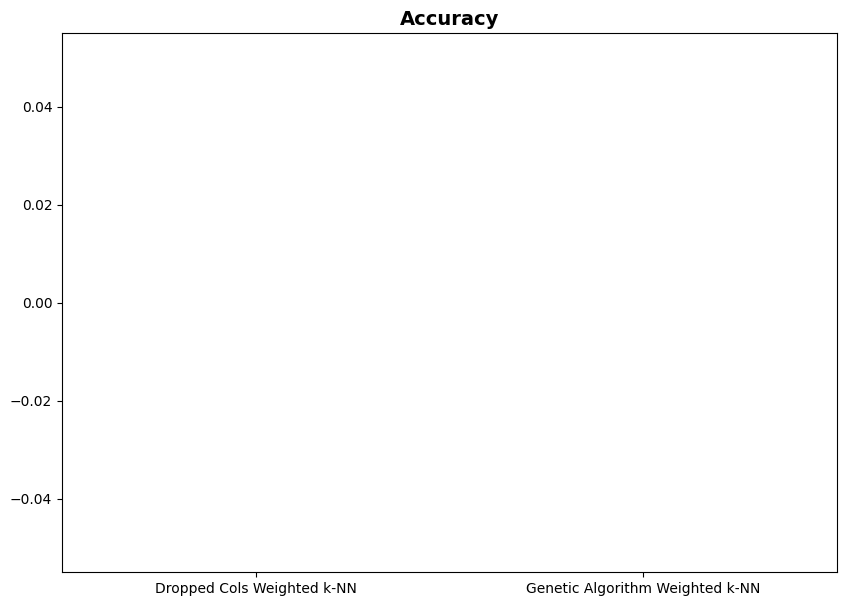

In [129]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')

# data = [dropped_weight_avg_acc, NN_acc, RFC_acc, XGB_acc]
# 
# x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

data = [dropped_weight_avg_acc, GA_weight_acc]

x_axis = ['Dropped Cols Weighted k-NN', 'Genetic Algorithm Weighted k-NN']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('IG and GA Accuracy.svg')

# show plot
plt.show()

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')

data = [avg_acc, dropped_weight_avg_acc, GA_weight_acc]

x_axis = ['Unweighted k-NN', 'Dropped Cols Weighted k-NN', 'Genetic Algorithm Weighted k-NN']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Unweighted, IG and GA Accuracy.svg')

# show plot
plt.show()


In [124]:
def weight_manipulation(num_of_population,num_of_weights,weights):

    genetic_weights = np.empty((num_of_population,num_of_weights))

    np_weights = np.array(weights)

    # print("weights : ", np_weights.shape)
    # print("Chama: ", genetic_weights.shape)

    if(np_weights.ndim == 1):

        for i in range(0, num_of_population):
            genetic_weights[i] = weights * np.random.rand(len(weights))

        # print("Huh: " ,genetic_weights.shape)

        return genetic_weights

    else :

        for row in range(num_of_population):
            # Multiply each element in the row by a random factor
            # The random factor must have the same number of columns as the weight matrix
            genetic_weights[row] = np_weights[row] * np.random.rand(np_weights.shape[1])

    return genetic_weights

In [133]:
def get_weight_manipulated_acc(num_of_population, genetic_weights):

    rows, columns = genetic_weights.shape

    population_data = np.empty(columns+1)
    population_data_sorted = np.empty((num_of_population,columns))

    for population in range(num_of_population):

        Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
        Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)

        TP = TN = FP = FN =0

        for p in range(len(Test_Data)):
            point=Test_Data.iloc[p]
            NBRS=Nearest_Neighbors(point, Train_Data, genetic_weights[population] , "num")
            Label=KNN(3,NBRS)
            if (Label==point["num"] and Label==1):
                TP+=1
            if (Label==point["num"] and Label==0):
                TN+=1
            if (Label!=point["num"] and Label==1):
                FP+=1
            if (Label!=point["num"] and Label==0):
                FN+=1
        A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)

        accuracy = A_dropped_weighted*100

        accuracy_list.append(accuracy)
        
        # print("Pop data before change: ", population_data) 
        # 
        # print("This is the loop iteration index, ", population)
        
        if(population == 0):
            population_weights_with_accuracy = np.append(genetic_weights[population], accuracy)  # the current populations weight and its accuracy 
            print("This is population_weights_with_accuracy, ", population_weights_with_accuracy, "\n")
            population_data[:] = population_weights_with_accuracy
            print("This is population_data inside of the if, ", population_data, "\n")
        else:
            
            population_weights_with_accuracy = np.append(genetic_weights[population], accuracy)  # the current populations weight and its accuracy 
            print("This is population_weights_with_accuracy, ", population_weights_with_accuracy, "\n")
            population_data = np.append(population_data,population_weights_with_accuracy)  # unsorted full generation data which holds weight and accuracy of each population
            print("This is population_data inside the else, ", population_data, "\n")
            population_data_sorted = population_data[np.argsort(population_data)[::-1]] # sorted full generations 
            print("This is population_data_sorted, ", population_data_sorted, "\n")

    return population_data_sorted

In [143]:
population_data_sorted[0]

np.float64(0.31820501860487105)

In [134]:
num_of_population = 20
num_of_weights = len(heart_swagger)

generations = 1

accuracy_list = []

# Dictionary to hold generations data
ig_generations_data = {}

for gen_num in range(generations):

    if gen_num == 0:

        genetic_weights = weight_manipulation(num_of_population, num_of_weights,heart_swagger)

        population_data_sorted = get_weight_manipulated_acc(num_of_population, genetic_weights)
        ig_generations_data[f'Generation_{gen_num + 1}'] = population_data_sorted
    else :

        population_data_sorted[-10:] = population_data_sorted[:10]

        for i in range(num_of_population):
            genetic_weights[i] = population_data_sorted[i][:7]

        genetic_weights = weight_manipulation(num_of_population, num_of_weights, genetic_weights)

        population_data_sorted = get_weight_manipulated_acc(num_of_population, genetic_weights)
        ig_generations_data[f'Generation_{gen_num + 1}'] = population_data_sorted
    
    

This is population_weights_with_accuracy,  [7.10348746e-02 4.20577266e-02 1.09914678e-01 1.30703563e-01
 7.98785504e-02 1.60394017e-01 2.82528096e-01 7.87564767e+01] 

This is population_data inside of the if,  [7.10348746e-02 4.20577266e-02 1.09914678e-01 1.30703563e-01
 7.98785504e-02 1.60394017e-01 2.82528096e-01 7.87564767e+01] 

This is population_weights_with_accuracy,  [1.56570237e-01 1.45030429e-01 3.59798475e-02 1.37346833e-01
 2.79822790e-02 5.80656682e-02 1.75385123e-01 7.92746114e+01] 

This is population_data inside the else,  [7.10348746e-02 4.20577266e-02 1.09914678e-01 1.30703563e-01
 7.98785504e-02 1.60394017e-01 2.82528096e-01 7.87564767e+01
 1.56570237e-01 1.45030429e-01 3.59798475e-02 1.37346833e-01
 2.79822790e-02 5.80656682e-02 1.75385123e-01 7.92746114e+01] 

This is population_data_sorted,  [7.92746114e+01 7.87564767e+01 2.82528096e-01 1.75385123e-01
 1.60394017e-01 1.56570237e-01 1.45030429e-01 1.37346833e-01
 1.30703563e-01 1.09914678e-01 7.98785504e-02 7.1034

In [123]:
for i in range(0,20):
    print(ig_generations_data["Generation_1"][i][7])

IndexError: invalid index to scalar variable.